# Using GenericTensorNetworks.jl to quantify MIS'

In this notebook you'll learn how to use QuEra's `GenericTensorNetworks.jl` package to quantify certain properties of the Maximum Indpeendent Set (MIS)'s Rydberg blockaded atoms can make  classically. This can be useful to verify MIS results obtained from hardware/simulation or get an idea of what hardware/simulation may give you.

`GenericTensorNetworks` uses Tensor Networks to compute solution space properties of hard combinatorial optimization problems. In our case we want to be able to get the number of possible MISs/(Independent Sets) ISs given an arbitrary graph as well as visualize what these MIS solutions might look like. 

## Generating A Graph

Let's begin by generating a Unit Disk Graph from our atom positions. First, we'll take advantage of Bloqade's built-in lattice generation features to give us some atom positions. You can also plug in your custom positions using Bloqade's [`AtomList`]([https://queracomputing.github.io/Bloqade.jl/dev/lattices/#BloqadeLattices.AtomList). 

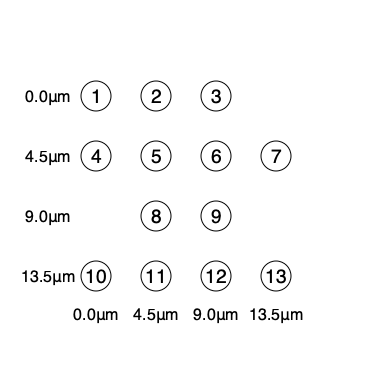

In [2]:
using Bloqade
using Random
using PythonCall
plt = pyimport("matplotlib.pyplot");

# seed random number generator for replicatable results
Random.seed!(14)
# generate list of atom positions based on a 4x4 Square lattices with 4.5 micrometers between atoms.
# Then drop atom positions from the square lattice with probability 0.2
atoms = generate_sites(SquareLattice(), 4, 4; scale = 4.5) |> random_dropout(0.2)

We can now plot the Unit Disk Graph created from atoms blockading eachother via overlapping blockade radii to get an idea of what the graph looks like. Keep in mind that the blockade radius is dependent on the Rabi frequency you select giving you the freedom to choose what the blockade radius may be in your Analog Hamiltonian Simulation program.

For this example, we choose the blockade radius to be 7.5 micrometers.

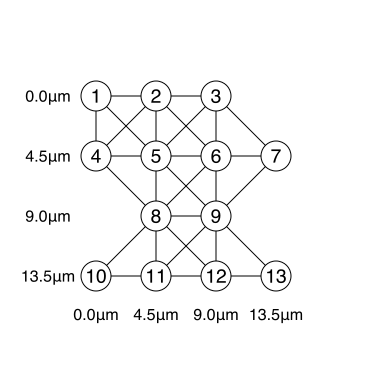

In [5]:
Bloqade.plot(atoms, blockade_radius=7.5)

We'll need to turn these atoms into a graph object representing the Unit Disk Graph before plugging things into GenericTensorNetworks with the following Bloqade function:

In [6]:
graph = BloqadeMIS.unit_disk_graph(atoms, 7.5)

{13, 29} undirected simple Int64 graph

## Getting Useful MIS Data

With the atoms now in proper graph format we can start to investigate some interesting MIS-related values.

### MIS Size

Let's first try finding just how many vertices the MIS of our graph should have.

We first create a problem for GenericTensorNetworks:

In [8]:
using GenericTensorNetworks
problem = IndependentSet(graph; optimizer=TreeSA())

IndependentSet{OMEinsum.SlicedEinsum{Int64, OMEinsum.DynamicNestedEinsum{Int64}}, NoWeight}(OMEinsum.SlicedEinsum{Int64, OMEinsum.DynamicNestedEinsum{Int64}}(Int64[], 7, 7 -> 
├─ 7
└─ 6∘7, 7∘6 -> 7
   ├─ 3∘6∘7, 7∘3 -> 6∘7
   │  ├─ 9∘3∘6, 7∘9 -> 3∘6∘7
   │  │  ├─ 2∘3∘6, 9∘6∘3∘2 -> 9∘3∘6
   │  │  │  ├─ 2∘6, 3∘6 -> 2∘3∘6
   │  │  │  │  ⋮
   │  │  │  │  
   │  │  │  └─ 2∘9∘6∘5, 2∘5∘3 -> 9∘6∘3∘2
   │  │  │     ⋮
   │  │  │     
   │  │  └─ 7∘9
   │  └─ 3, 3∘7 -> 7∘3
   │     ├─ 3
   │     └─ 3∘7
   └─ 6, 6∘7 -> 7∘6
      ├─ 6
      └─ 6∘7
), Graphs.SimpleGraphs.SimpleGraph{Int64}(29, [[2, 4, 5], [1, 3, 4, 5, 6], [2, 5, 6, 7], [1, 2, 5, 8], [1, 2, 3, 4, 6, 8, 9], [2, 3, 5, 7, 8, 9], [3, 6, 9], [4, 5, 6, 9, 10, 11, 12], [5, 6, 7, 8, 11, 12, 13], [8, 11], [8, 9, 10, 12], [8, 9, 11, 13], [9, 12]]), NoWeight(), Dict{Int64, Int64}())

And then we ask it to solve for the maximum size via `SizeMax()`

In [9]:
maximum_independent_set_size = GenericTensorNetworks.solve(problem, SizeMax())[]

4.0ₜ

The resulting answer tells us that there are a total of 4 vertices that make up the MIS. The subscript `t` denotes that the result is a [Tropical number](https://queracomputing.github.io/GenericTensorNetworks.jl/dev/ref/#TropicalNumbers.Tropical) but all you really have to worry about here to get the raw number for future usage is to access it via the `.n` attribute

In [10]:
maximum_independent_set_size.n

4.0

### MIS Count

We may also be interested in just how many combinations of the 4 vertices that constitute an MIS solution exist, e.g. the number of possible MISs. Once again, GenericTensorNetworks comes to the rescue with the `CountingMax()` option:

In [11]:
count_maximum_independent_sets = GenericTensorNetworks.solve(problem, CountingMax())[]

(4.0, 29.0)ₜ

This returns, again, the MIS size, which can be accessed from its tropical form via `.n` just like before:

In [12]:
count_maximum_independent_sets.n

4.0

And you can access the counts via `.c`:

In [13]:
count_maximum_independent_sets.c

29.0

The result tells us there are 29 possible combinations of 4 vertices that can constitute an MIS or in short, 29 possible MISs.

### IS Count

Another value of interest is the total number of Independent Sets rather than just the MISs. This can be accomplished via the `CountingAll()` option:

In [14]:
count_maximum_independent_sets = GenericTensorNetworks.solve(problem, CountingAll())[]

158.0

The value is already a `Float` so there is no need to access it from its Tropical form.

### MIS, MIS-1, MIS-2, MIS-N...

It can also be useful to see the MIS-1 or MIS-N solutions where the solution falls short of the true MIS by `n` vertices (e.g. if the MIS has 4 vertices, how many solutions could exist if we removed `n` of those vertices?)

There are two ways to go about this. To just get solutions up to a certain N you can feed the `CountingMax` option you saw before an integer argument. In this example we just want the MIS and MIS-1 so we plug in the number 2. If we wanted MIS, MIS-1, and MIS-2 we would plug in 3 and so on.

In [15]:
count_max2_independent_sets = GenericTensorNetworks.solve(problem, CountingMax(2))[]

66.0*x^3 + 29.0*x^4

The coefficients of the returned polynomial end up being the number of MIS and MIS-1 solutions. To be specific the last value is always the number of MIS solutions and the number before it will be the MIS-1 count, MIS-2 count, etc. 

In [16]:
count_max2_independent_sets.coeffs

(66.0, 29.0)

If you want all possible MIS-Ns from 1 to the total number of vertices in the MIS you can just obtain the full graph polynomial where the coefficients indicate the MIS count, then the MIS-1 count, all the way to zero vertices. (can you understand why the coefficient of the linear monomial is 13 here?)

In [17]:
independence_polynomial = GenericTensorNetworks.solve(problem, GraphPolynomial(; method=:finitefield))[]

Polynomial(1 + 13*x + 49*x^2 + 66*x^3 + 29*x^4)

In [18]:
independence_polynomial.coeffs

5-element Vector{BigInt}:
  1
 13
 49
 66
 29

The bottom-most element of the vector is the MIS and the item above it is MIS-1, then MIS-2, etc. 

## Visualizing Useful MIS Data

We promised in the introductory paragraph that you could also visualize what the resulting optimal MIS looks like. There are two ways to go about this. To just get a single MIS solution you can do the following: 

In [19]:
max_config = GenericTensorNetworks.solve(problem, SingleConfigMax(; bounded=false))[]

(4.0, ConfigSampler{13, 1, 1}(0100001100001))ₜ

We can now plot this via the following:

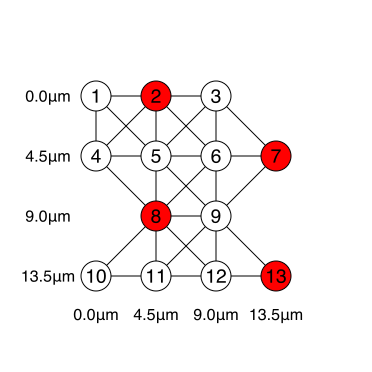

In [20]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b ∈ max_config.c.data])

To get all possible MISs you can opt for the `ConfigsMax` option instead of `SingleConfigMax`

In [21]:
all_max_configs = GenericTensorNetworks.solve(problem, ConfigsMax(; bounded=false))[]

(4.0, {1010000001001, 0011000001001, 1010000000101, 0011000000101, 1010000001010, 0011000001010, 1010000100001, 1010000011000, 0011000011000, 1000010001001, 0001010001001, 1000010000101, 0001010000101, 1000010001010, 0001010001010, 1000001001001, 0001001001001, 1000001000101, 0001001000101, 1000001001010, 0001001001010, 1000001100001, 0000101001001, 0000101000101, 0000101001010, 0100001001001, 0100001000101, 0100001001010, 0100001100001})ₜ

And then index through the bitstrings:

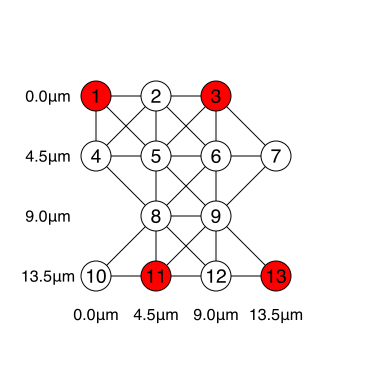

In [22]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b ∈ all_max_configs.c.data[3]])